In [1]:
import os
import numpy as np
import pandas as pd
import sys
import json
import networkx as nx
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import math
from glob import glob

# Add rpy2
%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(ComplexHeatmap)
    library(cowplot)
    library(facefuns)
    library(factoextra)
    library(FactoMineR)
    library(ggh4x)
    library(ggraph)
    library(ggpubr)
    library(ggrain)
    library(ggridges)
    library(ggseg)
    library(ggsignif)
    library(ggVennDiagram)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(VennDiagram) 
})


# Set cowplot theme
theme_set(theme_cowplot())

In [7]:
# load pyspi SPI info
pyspi_SPI_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

# Load results for within-participant classification
intra_individual_classification_path = "/Users/abry4213/data/Cogitate_MEG/derivatives/classification_results/within_participants"
intra_individual_classification_res_list = []

# for classification_file in os.listdir(intra_individual_classification_path):
for classification_file in glob(f"{intra_individual_classification_path}/*Logistic*.csv"):
    subject_id = os.path.basename(classification_file).split("_")[0]
    classification_df = pd.read_csv(classification_file)

    # Drop the 'comparison' column
    if "comparison" in classification_df.columns:
        classification_df = classification_df.drop(columns=["comparison"])

    if "relevance_type" in classification_file:
        classification_df["Classification_Type"] = "Relevance"
    else:
        classification_df["Classification_Type"] = "Stimulus Type"

    # Rename column from subject_id to "subject_id"
    classification_df = classification_df.rename(columns={subject_id: "subject_id"})
    classification_df["subject_id"] = subject_id

    # Filter to results with accuracy > 0.6
    classification_df = classification_df.filter(["subject_id", "SPI", "Classification_Type", "stimulus_presentation", "meta_ROI_from", "meta_ROI_to", "accuracy"])

    # Append results
    intra_individual_classification_res_list.append(classification_df)

# Concatenate all classification results
intra_individual_classification_res = pd.concat(intra_individual_classification_res_list)

# One dataframe for the >=0.6 results
intra_individual_classification_res_top = intra_individual_classification_res.query("accuracy >= 0.6")

In [26]:
# Iterate over thresholds from 0.6 to 1.0, in increments of 0.05, to see how many SPIs remain for each individual
thresholds = np.arange(0.6, 1.05, 0.05)
SPIs_individuals_list = []

for threshold in thresholds:
    threshold_rounded = round(threshold, 2)
    SPIs_individuals = (intra_individual_classification_res_top
                        .query(f"accuracy >= {threshold_rounded} & Classification_Type=='Stimulus Type'")
                        .drop_duplicates(['subject_id', 'SPI'])
                        .groupby("subject_id")
                        .size()
                        .reset_index(name="num_SPIs")
                        .assign(threshold=threshold_rounded))
    SPIs_individuals_list.append(SPIs_individuals)

SPIs_individuals_threshold_counts = pd.concat(SPIs_individuals_list)
SPIs_individuals_threshold_counts.head()

,subject_id,num_SPIs,threshold
0,sub-CA103,198,0.6
1,sub-CA106,200,0.6
2,sub-CA107,200,0.6
3,sub-CA108,200,0.6
4,sub-CA109,200,0.6


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


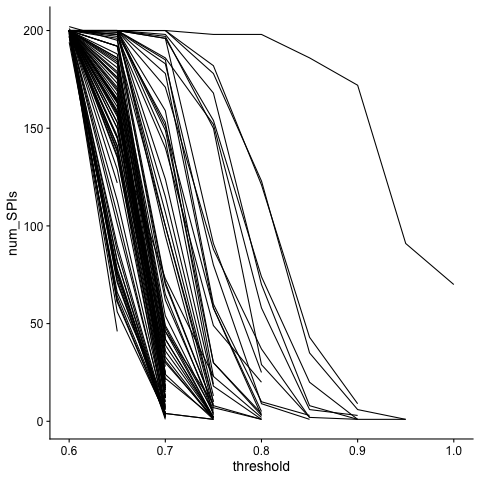

In [28]:
%%R -i SPIs_individuals_threshold_counts

SPIs_individuals_threshold_counts %>% 
    mutate(subject_id = fct_reorder(subject_id, num_SPIs, .fun=mean)) %>%
    ggplot(aes(x=threshold, y=num_SPIs, group=subject_id)) + 
    geom_line() +
    theme(legend.position="none")